In [1]:
# Importing the 4 standard libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Importing metrics from sklearn for model performance
from sklearn import metrics
from time import time # Measure how long my code takes to run

from sklearn.tree import DecisionTreeClassifier # The classifier algorithm
from sklearn import tree # Visualise the trees
from sklearn.model_selection import train_test_split # Train test splitting
from sklearn.model_selection import GridSearchCV # Helps us select the best parameters for model
from sklearn.metrics import (confusion_matrix, accuracy_score) # Import accuracy and confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

Import clean dataset

In [2]:
df = pd.read_csv('cleaned.csv')

Function to help with evaluation

In [3]:
## Function used to evaluate results
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

# Train test split

In [4]:
# Setting up the variables for the train/testing
y = df['Churn Value']
X = df.drop(columns=['Churn Value', 'Churn Label', 'Churn Reason'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering

In [5]:
# Define a function to do all our feature engineering for us.
def feature_engineering(df):
    binary_cols = ['Senior Citizen','Gender', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
    binary_dict = {'No' : '0', 'Male' : '0', 'Female' : '1', 'Yes' : '1'}
    df = df.drop(columns=['Count', 'Country', 'State', 'City','Lat Long','Zip Code','CustomerID'])
    for i in binary_cols:
        df[i] = df[i].map(binary_dict)
        df[i] = df[i].astype(int) # Converts the types from obj to int
    ohe_cols = ["Multiple Lines","Internet Service","Online Security","Online Backup","Device Protection","Tech Support","Streaming TV","Streaming Movies","Contract","Payment Method"]
    for x in ohe_cols:
        df = pd.get_dummies(data = df, columns = [x] , prefix= x, drop_first=False) # Not dropping first column as model is non parametric
    return df

In [6]:
# Apply it to our train and test variables.
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
X_train.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
6021,35.280113,-118.962329,0,0,1,0,24,1,1,93.00,...,0,0,1,1,0,0,0,0,1,0
3404,36.276880,-117.033326,1,0,1,0,40,1,1,78.85,...,1,0,0,1,0,0,0,1,0,0
5474,40.531257,-122.148139,0,0,1,0,4,1,0,65.60,...,1,0,0,1,0,0,0,0,1,0
5515,39.117018,-120.212535,1,0,0,0,4,1,0,55.50,...,1,0,0,1,0,0,0,1,0,0
6328,37.186141,-121.843554,1,0,1,1,64,1,0,24.90,...,0,1,0,0,1,0,0,0,0,1


In [7]:
feature_cols = X_train.columns
len(feature_cols)

42

Just having a go making a simple DT work on our data

In [8]:
# Defining the decision tree classifier
firstdt = DecisionTreeClassifier(max_depth=3, random_state=1)
firstdt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [9]:
# These are the classes that we get
firstdt.classes_

array([0, 1], dtype=int64)

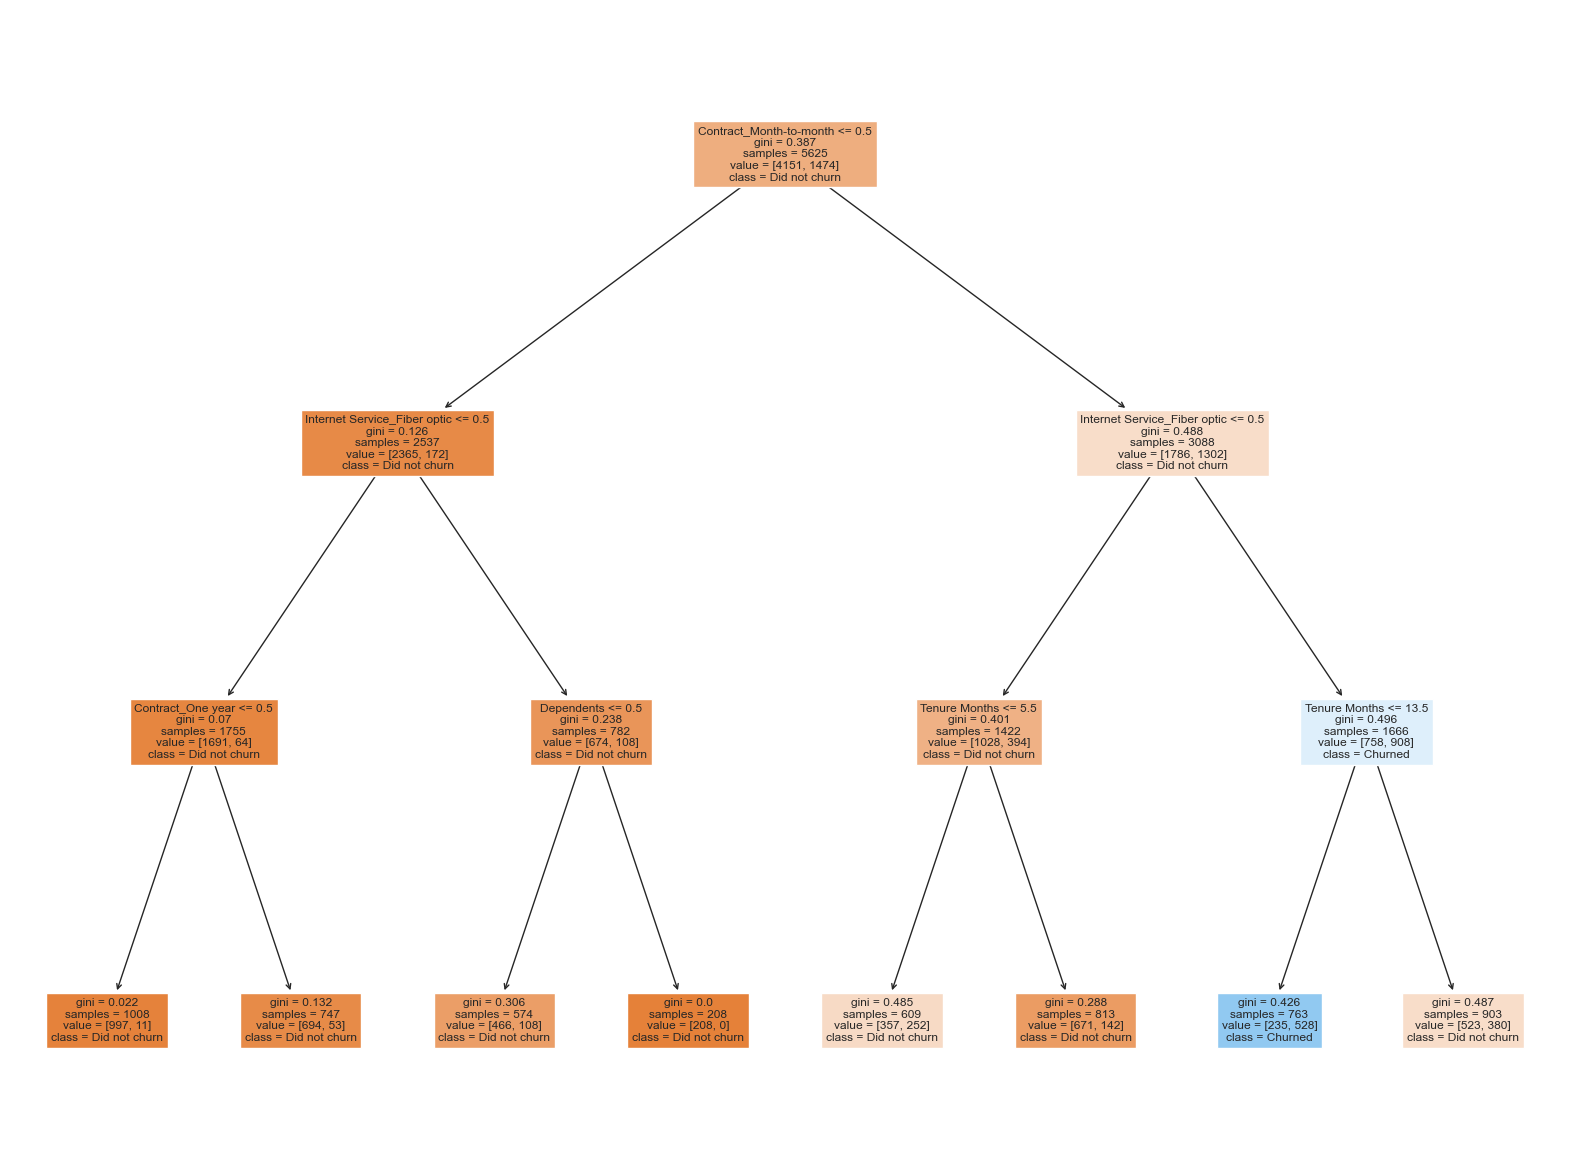

In [10]:
# Visualise the tree
fig = plt.figure(figsize=(20,15))
thing = tree.plot_tree(firstdt,
                       feature_names=X_train.columns,
                       class_names=['Did not churn', 'Churned'],
                       filled=True)

In [11]:
# score - does predict, and calculates scores! - The score in sklearn means accuracy
print(f'Score on training set: {firstdt.score(X_train, y_train)}')
print(f'Score on testing set: {firstdt.score(X_test, y_test)}')

Score on training set: 0.7900444444444444
Score on testing set: 0.7860696517412935


Have a go at grid search.

In [12]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [3, 5, 7, 10],
                                  'min_samples_split': [50, 100, 150, 200, 500, 1000], # Minimum number of samples to make a split
                                  'min_samples_leaf': [20, 30, 40, 50, 60, 70], # Minimum number of samples to have in a leaf
                                  'max_features':[2,42]}, # How many features it will use to make a decision
                    cv = 10, # Number of folds it uses
                    refit = True, # Should I learn from previous iterations
                    verbose = 2, # Either 0,1 or 2 how much should I tell the programmer
                    scoring = 'accuracy') # Which metric am I looking to prioritise

In [13]:
# Timing the grid search using the timing library
now = time()
grid.fit(X_train, y_train)
print(f' Time in seconds: {time() - now}')

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=20, min_samples_split=50; total time=   0.0s
[CV] END max_depth=3, max_features=

In [14]:
# Check the best parameters resulting from our search!
grid.best_params_

{'max_depth': 7,
 'max_features': 42,
 'min_samples_leaf': 70,
 'min_samples_split': 500}

In [15]:
# What is the best accuracy you managed to achieve via your search?
# This is not the best possible accuracy we can get on the training set
# This is the best accuracy that makes sure we represent the training set, as well as any other similar looking data
# i.e. (in our case, the test set X_test) in a similar way -- i.e. avoid overfitting

# We achieved this by folding the training set (X_train) into 10 splits/folds -- using 10-fold Cross Validation - most robust
grid.best_score_

0.7992971056174661

In [16]:
# This is the best model I came up with
grid.best_estimator_

DecisionTreeClassifier(max_depth=7, max_features=42, min_samples_leaf=70,
                       min_samples_split=500)

In [17]:
# Using the best parameters as defined above
robustdt = DecisionTreeClassifier(max_depth=7, max_features=42, min_samples_leaf=70,
                                  min_samples_split=500)

In [18]:
# Fit the best model on train
robustdt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features=42, min_samples_leaf=70,
                       min_samples_split=500)

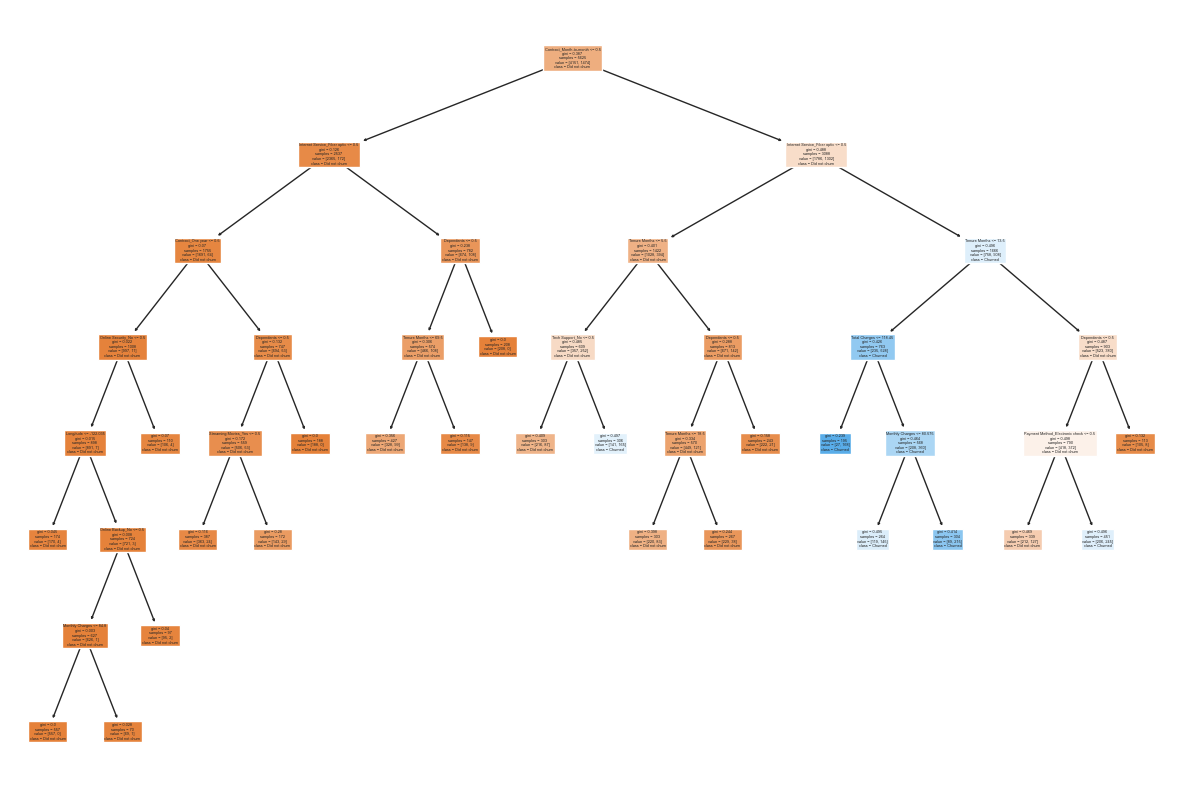

In [19]:
# Plot the robust model.

fig = plt.figure(figsize=(15,10))
thing = tree.plot_tree(robustdt,
                       feature_names=X_train.columns,
                       class_names=['Did not churn', 'Churned'],
                       filled=True)

In [20]:
# Evaluate model.
print(f'Score on training set: {robustdt.score(X_train, y_train)}')
print(f'Score on testing set: {robustdt.score(X_test, y_test)}')

Score on training set: 0.8012444444444444
Score on testing set: 0.7910447761194029


Get a list of the feature importance - see what our root node is?

In [21]:
importance = list(zip(X_train.columns, list(robustdt.feature_importances_)))

In [22]:
# Shows the features and how weighted they are.
importance

[('Latitude', 0.0),
 ('Longitude', 0.0001441932043464258),
 ('Gender', 0.0),
 ('Senior Citizen', 0.0),
 ('Partner', 0.0),
 ('Dependents', 0.07291683475330973),
 ('Tenure Months', 0.16198432904197113),
 ('Phone Service', 0.0),
 ('Paperless Billing', 0.0),
 ('Monthly Charges', 0.010245190065182307),
 ('Total Charges', 0.02179053762390922),
 ('Multiple Lines_No', 0.0),
 ('Multiple Lines_No phone service', 0.0),
 ('Multiple Lines_Yes', 0.0),
 ('Internet Service_DSL', 0.0),
 ('Internet Service_Fiber optic', 0.17559062938664036),
 ('Internet Service_No', 0.0),
 ('Online Security_No', 0.00023148986406207702),
 ('Online Security_No internet service', 0.0),
 ('Online Security_Yes', 0.0),
 ('Online Backup_No', 8.799062278899057e-05),
 ('Online Backup_No internet service', 0.0),
 ('Online Backup_Yes', 0.0),
 ('Device Protection_No', 0.0),
 ('Device Protection_No internet service', 0.0),
 ('Device Protection_Yes', 0.0),
 ('Tech Support_No', 0.028002389072777904),
 ('Tech Support_No internet servic

In [23]:
# This calculates the feature with the highest importance and what column it is.
cols = []
fimportances = []

for x in importance:
    cols.append(x[0])
    fimportances.append(x[1])
maxindex = fimportances.index(max(fimportances))
print(f' The max feature importance is {fimportances[35]} for {cols[35]}')

 The max feature importance is 0.5046910325687443 for Contract_Month-to-month


In [24]:
# This shows us the features that have 0 importance.
zeroFimportanceCols = []
for i in range(len(cols)):
    if fimportances[i] == 0.0:
        zeroFimportanceCols.append(cols[i])

print(f' The cols that aren\'t used by the DT are: {zeroFimportanceCols}')

 The cols that aren't used by the DT are: ['Latitude', 'Gender', 'Senior Citizen', 'Partner', 'Phone Service', 'Paperless Billing', 'Multiple Lines_No', 'Multiple Lines_No phone service', 'Multiple Lines_Yes', 'Internet Service_DSL', 'Internet Service_No', 'Online Security_No internet service', 'Online Security_Yes', 'Online Backup_No internet service', 'Online Backup_Yes', 'Device Protection_No', 'Device Protection_No internet service', 'Device Protection_Yes', 'Tech Support_No internet service', 'Tech Support_Yes', 'Streaming TV_No', 'Streaming TV_No internet service', 'Streaming TV_Yes', 'Streaming Movies_No', 'Streaming Movies_No internet service', 'Contract_Two year', 'Payment Method_Bank transfer (automatic)', 'Payment Method_Credit card (automatic)', 'Payment Method_Mailed check']


In [25]:
# This shows us features that have some importance (note some are very small)
fimportanceCols = []
for i in range(len(cols)):
    if fimportances[i] > 0.0:
        fimportanceCols.append(cols[i])

print(f' The cols that are used by the DT are: {fimportanceCols}')

 The cols that are used by the DT are: ['Longitude', 'Dependents', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'Internet Service_Fiber optic', 'Online Security_No', 'Online Backup_No', 'Tech Support_No', 'Streaming Movies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Payment Method_Electronic check']


In [26]:
# The robust dt ended up using 13 features to make decisions
len(fimportanceCols)

13

# Results dataframes

Will use the following dataframe to store the results of above robust dt, baggingclassifier dt, randomforest and extra trees
This has been created in order to make use of the getresults() above

In [27]:
# Save the results in a dataframe
train_results = X_train.copy() # Copy the training set
train_results['rdt_y_pred'] = robustdt.predict(X_train) # Create prediction
train_results['y_real'] = y_train # Attach the actual values
train_results['rdt_y_prob'] = robustdt.predict_proba(X_train)[:,1] # Get the probabilities

train_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob
6021,35.280113,-118.962329,0,0,1,0,24,1,1,93.00,...,1,0,0,0,0,1,0,1,0,0.543237
3404,36.276880,-117.033326,1,0,1,0,40,1,1,78.85,...,1,0,0,0,1,0,0,0,0,0.374631
5474,40.531257,-122.148139,0,0,1,0,4,1,0,65.60,...,1,0,0,0,0,1,0,1,0,0.539216
5515,39.117018,-120.212535,1,0,0,0,4,1,0,55.50,...,1,0,0,0,1,0,0,1,0,0.539216
6328,37.186141,-121.843554,1,0,1,1,64,1,0,24.90,...,0,1,0,0,0,0,1,0,0,0.000000


In [28]:
# Do the same on the testing set

test_results = X_test.copy() # Create a copy of testing set
test_results['rdt_y_pred'] = robustdt.predict(X_test) # Attach the predictions
test_results['y_real'] = y_test # Attach the actual values
test_results['rdt_y_prob'] = robustdt.predict_proba(X_test)[:,1] # Attach the probabilities of our predictions

test_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob
2476,37.244307,-119.470256,1,0,1,0,42,1,0,25.25,...,0,0,1,0,0,1,0,0,0,0.000000
6773,33.890853,-118.297967,0,0,0,0,43,0,0,44.15,...,0,1,0,0,0,1,0,0,0,0.168605
6116,36.600193,-120.153393,1,0,0,0,27,1,1,89.20,...,1,0,0,0,0,1,0,1,0,0.543237
3047,40.021787,-122.127576,0,0,0,0,65,1,1,19.55,...,0,0,1,0,1,0,0,0,0,0.022989
4092,38.683605,-120.811852,1,0,0,0,29,1,1,71.00,...,0,1,0,0,1,0,0,0,0,0.168605


# Evaluate results

Evaluation of the robust dt on training and test data

In [29]:
# Training data eval
get_results(y_train, train_results['rdt_y_pred'])

The confusion matrix for your predictions is:
[[3569  582]
 [ 536  938]] 

The accuracy of your model is: 0.8012444444444444
The recall of your model is: 0.6363636363636364
The precision of your model is: 0.6171052631578947
The F1-score of your model is: 0.6265865063460253


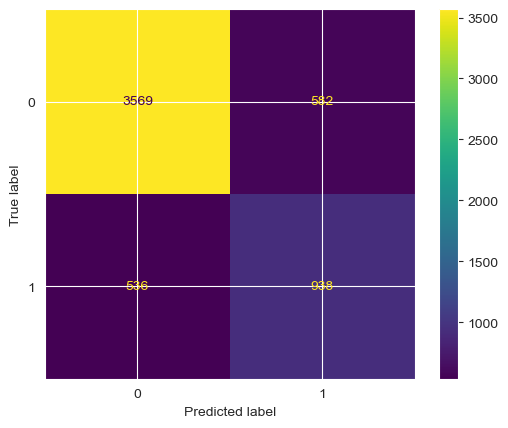

In [30]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train,train_results['rdt_y_pred'])).plot()
plt.show()

In [31]:
# testing data eval
get_results(y_test, test_results['rdt_y_pred'])

The confusion matrix for your predictions is:
[[870 142]
 [152 243]] 

The accuracy of your model is: 0.7910447761194029
The recall of your model is: 0.6151898734177215
The precision of your model is: 0.6311688311688312
The F1-score of your model is: 0.6230769230769231


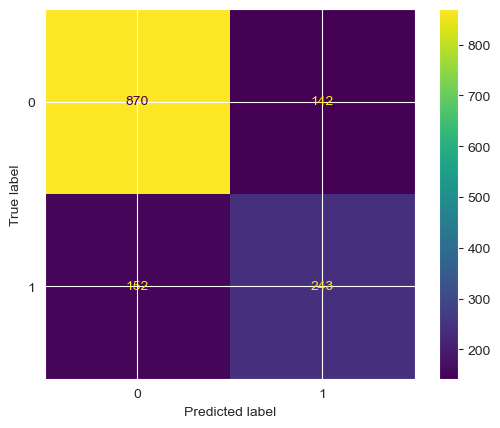

In [32]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,test_results['rdt_y_pred'])).plot()
plt.show()

## Random Forests

In [33]:
rf = RandomForestClassifier(n_estimators=50)
rf_score = cross_val_score(rf, X_train, y_train, cv=5)
print(rf_score)

[0.80888889 0.78044444 0.78133333 0.79022222 0.80355556]


In [34]:
#  Average accuracy of folds for rf
sum(rf_score)/len(rf_score)

0.792888888888889

In [35]:
min(rf_score)

0.7804444444444445

In [36]:
max(rf_score)

0.8088888888888889

## Extra Trees


In [37]:
et = ExtraTreesClassifier(n_estimators=50)
et_score = cross_val_score(et, X_train, y_train, cv=5)
print(f'Extra Random scored {et_score}')

Extra Random scored [0.78755556 0.78755556 0.77511111 0.77333333 0.79111111]


In [38]:
# Average accuracy of folds for et
sum(et_score)/len(et_score)

0.7829333333333335

In [39]:
min(et_score)

0.7733333333333333

In [40]:
max(et_score)


0.7911111111111111

In [41]:
# by using extra trees, the variance is lower than what was seen on the random forest, however the average accuracy decreased slightly

# Gridsearch to find best parameters for rf

In [42]:
rf_params = {
    'n_estimators': [100, 150, 200], ## Number of trees to use # 3 options
    'max_depth': [None, 1, 2, 3, 4, 5], ## 6 options
}

# Apply the cross validated grid search on RF
gs = GridSearchCV(rf, verbose=2, param_grid=rf_params, cv=5)

# Fit the grid search result on train
gs.fit(X_train, y_train)

# Print out the best score
print(gs.best_score_)

# Print out the parameters for our model
gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=150; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=150; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=150; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=150; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=150; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.5s
[CV] END ...................max_depth=None, n_es

{'max_depth': 5, 'n_estimators': 100}

In [43]:
## Check the accuracy of our model - best accuracy score but not the robust RF models accuracy - robust RF has a small diff between train data and on other data i.e. test

gs.score(X_train, y_train)

0.8103111111111111

In [44]:
# to get robust rf model, we will use the best parameters provided by the gridsearch

gs.best_params_


{'max_depth': 5, 'n_estimators': 100}

In [45]:
# accuracy of robust rf

gs.best_score_

0.7984

In [46]:
gs.best_estimator_

RandomForestClassifier(max_depth=5)

# Making Predictions with robust rf model

In [47]:
# predicting on train

rf = RandomForestClassifier(max_depth=5, n_estimators=150) #using the basic best results found above.
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=150)

In [48]:
train_results['rf_y_pred']=rf.predict(X_train)
train_results['rf_y_prob']=rf.predict_proba(X_train)[:,1]    # get the probabilities of churning

In [49]:
train_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob
6021,35.280113,-118.962329,0,0,1,0,24,1,1,93.00,...,0,0,0,1,0,1,0,0.543237,1,0.515525
3404,36.276880,-117.033326,1,0,1,0,40,1,1,78.85,...,0,0,1,0,0,0,0,0.374631,0,0.342597
5474,40.531257,-122.148139,0,0,1,0,4,1,0,65.60,...,0,0,0,1,0,1,0,0.539216,0,0.450812
5515,39.117018,-120.212535,1,0,0,0,4,1,0,55.50,...,0,0,1,0,0,1,0,0.539216,0,0.421197
6328,37.186141,-121.843554,1,0,1,1,64,1,0,24.90,...,0,0,0,0,1,0,0,0.000000,0,0.030949


In [50]:
# predicting on test

test_results['rf_y_pred']=rf.predict(X_test)
test_results['rf_y_prob']=rf.predict_proba(X_test)[:,1]

In [51]:
test_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob
2476,37.244307,-119.470256,1,0,1,0,42,1,0,25.25,...,1,0,0,1,0,0,0,0.000000,0,0.033086
6773,33.890853,-118.297967,0,0,0,0,43,0,0,44.15,...,0,0,0,1,0,0,0,0.168605,0,0.158534
6116,36.600193,-120.153393,1,0,0,0,27,1,1,89.20,...,0,0,0,1,0,1,0,0.543237,0,0.411934
3047,40.021787,-122.127576,0,0,0,0,65,1,1,19.55,...,1,0,1,0,0,0,0,0.022989,0,0.021387
4092,38.683605,-120.811852,1,0,0,0,29,1,1,71.00,...,0,0,1,0,0,0,0,0.168605,0,0.183411


# Evaluation of rf Model

In [52]:
get_results(y_train, train_results['rf_y_pred'])

The confusion matrix for your predictions is:
[[3899  252]
 [ 819  655]] 

The accuracy of your model is: 0.8096
The recall of your model is: 0.4443690637720488
The precision of your model is: 0.7221609702315325
The F1-score of your model is: 0.5501889962200756


In [53]:
get_results(y_test, test_results['rf_y_pred'])

The confusion matrix for your predictions is:
[[951  61]
 [221 174]] 

The accuracy of your model is: 0.7995735607675906
The recall of your model is: 0.44050632911392407
The precision of your model is: 0.7404255319148936
The F1-score of your model is: 0.5523809523809523


## Comparing the performance of robust rf (found from gridsearch) against base logreg model on train and test

# Performance of base logreg on train

The confusion matrix for your predictions is:
    [[3828  323]
     [ 725  749]]

The accuracy of your model is: 0.8136888888888889
The recall of your model is: 0.5081411126187245
The precision of your model is: 0.6986940298507462
The F1-score of your model is: 0.5883739198743126

# Performance of base logreg on test

The confusion matrix for your predictions is:
[[959  53]
 [220 175]]

The accuracy of your model is: 0.8059701492537313
The recall of your model is: 0.4430379746835443
The precision of your model is: 0.7675438596491229
The F1-score of your model is: 0.5617977528089888

# Improving our results

In [54]:
X_train.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
6021,35.280113,-118.962329,0,0,1,0,24,1,1,93.00,...,0,0,1,1,0,0,0,0,1,0
3404,36.276880,-117.033326,1,0,1,0,40,1,1,78.85,...,1,0,0,1,0,0,0,1,0,0
5474,40.531257,-122.148139,0,0,1,0,4,1,0,65.60,...,1,0,0,1,0,0,0,0,1,0
5515,39.117018,-120.212535,1,0,0,0,4,1,0,55.50,...,1,0,0,1,0,0,0,1,0,0
6328,37.186141,-121.843554,1,0,1,1,64,1,0,24.90,...,0,1,0,0,1,0,0,0,0,1


In [55]:
# Starting with the random forrest
estimator = [50,100, 150, 200, 250, 300] # expand our range at the cost of
depth = [i + 1 for i in range(10)] # 0 depth is nonsensical
rf_params = {
    'n_estimators': estimator, ## Number of trees to use # 3 options
    'max_depth': depth, ## 6 options
}

# Apply the cross validated grid search on RF
gs_improv = GridSearchCV(rf, verbose=2, param_grid=rf_params, cv=5)

# Fit the grid search result on train
gs_improv.fit(X_train, y_train)

# Print out the best score
print(gs_improv.best_score_)

# Print out the parameters for our model
gs_improv.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.0s
[CV] END ......................max_depth=1, n_e

{'max_depth': 8, 'n_estimators': 250}

In [56]:
# So the best results was depth 10 and estimator 150 (when we ran it the other day im unsure as to why it changed now?). From an improved search.

# Predicting on train

rf2 = RandomForestClassifier(max_depth=10, n_estimators=150)
rf2.fit(X_train, y_train)
train_results['rf2_y_pred']=rf2.predict(X_train)
train_results['rf2_y_prob']=rf2.predict_proba(X_train)[:,1]

In [57]:
train_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob,rf2_y_pred,rf2_y_prob
6021,35.280113,-118.962329,0,0,1,0,24,1,1,93.00,...,0,1,0,1,0,0.543237,1,0.515525,1,0.591905
3404,36.276880,-117.033326,1,0,1,0,40,1,1,78.85,...,1,0,0,0,0,0.374631,0,0.342597,0,0.295393
5474,40.531257,-122.148139,0,0,1,0,4,1,0,65.60,...,0,1,0,1,0,0.539216,0,0.450812,0,0.280289
5515,39.117018,-120.212535,1,0,0,0,4,1,0,55.50,...,1,0,0,1,0,0.539216,0,0.421197,0,0.340280
6328,37.186141,-121.843554,1,0,1,1,64,1,0,24.90,...,0,0,1,0,0,0.000000,0,0.030949,0,0.013859


In [58]:
# predicting on test

test_results['rf2_y_pred']=rf2.predict(X_test)
test_results['rf2_y_prob']=rf2.predict_proba(X_test)[:,1]
test_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob,rf2_y_pred,rf2_y_prob
2476,37.244307,-119.470256,1,0,1,0,42,1,0,25.25,...,0,1,0,0,0,0.000000,0,0.033086,0,0.017179
6773,33.890853,-118.297967,0,0,0,0,43,0,0,44.15,...,0,1,0,0,0,0.168605,0,0.158534,0,0.125851
6116,36.600193,-120.153393,1,0,0,0,27,1,1,89.20,...,0,1,0,1,0,0.543237,0,0.411934,0,0.470011
3047,40.021787,-122.127576,0,0,0,0,65,1,1,19.55,...,1,0,0,0,0,0.022989,0,0.021387,0,0.012945
4092,38.683605,-120.811852,1,0,0,0,29,1,1,71.00,...,1,0,0,0,0,0.168605,0,0.183411,0,0.243698


# Evaluation
THIS IS A CLEAR EXAMPLE OF OVERFITTING! This might be explained by our depth being so high.
These results show that although our training data was accurate to a much higher degree than the previous model, this model didn't generalise well to the testing data being significantly lower accuracy.

In [59]:
get_results(y_train, train_results['rf2_y_pred'])

The confusion matrix for your predictions is:
[[3922  229]
 [ 391 1083]] 

The accuracy of your model is: 0.8897777777777778
The recall of your model is: 0.7347354138398915
The precision of your model is: 0.8254573170731707
The F1-score of your model is: 0.7774587221823402


In [60]:
get_results(y_test, test_results['rf2_y_pred'])

The confusion matrix for your predictions is:
[[922  90]
 [177 218]] 

The accuracy of your model is: 0.8102345415778252
The recall of your model is: 0.5518987341772152
The precision of your model is: 0.7077922077922078
The F1-score of your model is: 0.620199146514936


# Improving.. Again
Our main goal is to improve accuracy without over-fitting.

In [61]:
# Starting with the random forrest
estimator = [10*i for i in range(10,21)]
depth = [i + 1 for i in range(7)] # 0 depth is nonsensical, and lower to avoid over-fitting
rf_params = {
    'n_estimators': estimator, ## Number of trees to use # 3 options
    'max_depth': depth, ## 6 options
}

# Apply the cross validated grid search on RF
gs_improv2 = GridSearchCV(rf, verbose=2, param_grid=rf_params, cv=5)

# Fit the grid search result on train
gs_improv2.fit(X_train, y_train)

# Print out the best score
print(gs_improv2.best_score_)

# Print out the parameters for our model
gs_improv2.best_params_

Fitting 5 folds for each of 77 candidates, totalling 385 fits
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=110; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=110; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=110; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=110; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=110; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=120; total time=   0.0s
[CV] END ......................max_depth=1, n_e

{'max_depth': 7, 'n_estimators': 150}

In [62]:
# The best results vary (for some reason again) so we will use just one of the results.
rf3 = RandomForestClassifier(max_depth=7, n_estimators=110)
rf3.fit(X_train, y_train)
train_results['rf3_y_pred'] = rf3.predict(X_train)
train_results['rf3_y_prob'] = rf3.predict_proba(X_train)[:, 1]
train_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob,rf2_y_pred,rf2_y_prob,rf3_y_pred,rf3_y_prob
6021,35.280113,-118.962329,0,0,1,0,24,1,1,93.00,...,0,1,0,0.543237,1,0.515525,1,0.591905,1,0.555715
3404,36.276880,-117.033326,1,0,1,0,40,1,1,78.85,...,0,0,0,0.374631,0,0.342597,0,0.295393,0,0.357197
5474,40.531257,-122.148139,0,0,1,0,4,1,0,65.60,...,0,1,0,0.539216,0,0.450812,0,0.280289,0,0.420975
5515,39.117018,-120.212535,1,0,0,0,4,1,0,55.50,...,0,1,0,0.539216,0,0.421197,0,0.340280,0,0.390054
6328,37.186141,-121.843554,1,0,1,1,64,1,0,24.90,...,1,0,0,0.000000,0,0.030949,0,0.013859,0,0.017653


In [63]:
# predicting on test

test_results['rf3_y_pred'] = rf3.predict(X_test)
test_results['rf3_y_prob'] = rf3.predict_proba(X_test)[:, 1]
test_results.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob,rf2_y_pred,rf2_y_prob,rf3_y_pred,rf3_y_prob
2476,37.244307,-119.470256,1,0,1,0,42,1,0,25.25,...,0,0,0,0.000000,0,0.033086,0,0.017179,0,0.016407
6773,33.890853,-118.297967,0,0,0,0,43,0,0,44.15,...,0,0,0,0.168605,0,0.158534,0,0.125851,0,0.135838
6116,36.600193,-120.153393,1,0,0,0,27,1,1,89.20,...,0,1,0,0.543237,0,0.411934,0,0.470011,0,0.449081
3047,40.021787,-122.127576,0,0,0,0,65,1,1,19.55,...,0,0,0,0.022989,0,0.021387,0,0.012945,0,0.019766
4092,38.683605,-120.811852,1,0,0,0,29,1,1,71.00,...,0,0,0,0.168605,0,0.183411,0,0.243698,0,0.219175


# Results
We have selected this model as our best model because the overall accuracy has increased by 1.5% compared to the initial rf model, this is because the recall has increased by 11% and therefore has driven the increase of accuracy, and we are predicting less type two errors i.e. saying people have not churned when they have.
We ignored the loss of robustness between train and test in comparison between initial rf and rf3 as we have focused on the metrics accuracy and recall (the tradeoff is worth the loss of robustness)

In [64]:
get_results(y_train, train_results['rf3_y_pred'])

The confusion matrix for your predictions is:
[[3826  325]
 [ 659  815]] 

The accuracy of your model is: 0.8250666666666666
The recall of your model is: 0.5529172320217096
The precision of your model is: 0.7149122807017544
The F1-score of your model is: 0.6235654169854629


In [65]:
get_results(y_test, test_results['rf3_y_pred'])

The confusion matrix for your predictions is:
[[924  88]
 [182 213]] 

The accuracy of your model is: 0.8081023454157783
The recall of your model is: 0.5392405063291139
The precision of your model is: 0.707641196013289
The F1-score of your model is: 0.6120689655172413


# Creating Customer Lists
We will create the 500 top most likely to churn and the customer churn risk for all customers.

In [66]:
df_customer = pd.concat([test_results, train_results])
df_customer

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob,rf2_y_pred,rf2_y_prob,rf3_y_pred,rf3_y_prob
2476,37.244307,-119.470256,1,0,1,0,42,1,0,25.25,...,0,0,0,0.000000,0,0.033086,0,0.017179,0,0.016407
6773,33.890853,-118.297967,0,0,0,0,43,0,0,44.15,...,0,0,0,0.168605,0,0.158534,0,0.125851,0,0.135838
6116,36.600193,-120.153393,1,0,0,0,27,1,1,89.20,...,0,1,0,0.543237,0,0.411934,0,0.470011,0,0.449081
3047,40.021787,-122.127576,0,0,0,0,65,1,1,19.55,...,0,0,0,0.022989,0,0.021387,0,0.012945,0,0.019766
4092,38.683605,-120.811852,1,0,0,0,29,1,1,71.00,...,0,0,0,0.168605,0,0.183411,0,0.243698,0,0.219175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,37.722302,-122.491129,1,1,0,1,30,1,1,101.30,...,0,0,0,0.070796,0,0.288439,0,0.220935,0,0.298370
5191,38.121601,-120.133915,1,1,0,0,70,1,1,75.50,...,0,0,0,0.036364,0,0.064983,0,0.026647,0,0.053124
5226,38.493888,-122.777141,0,0,0,0,34,1,1,105.35,...,0,1,0,0.543237,0,0.398818,0,0.384881,0,0.410933
5390,39.467828,-120.841386,0,0,0,0,9,1,0,70.05,...,1,1,0,0.549242,1,0.525830,0,0.399566,1,0.503528


In [67]:
# We now want to remove all rows where y_real = 1 i.e the customer has churned.
df_customer = df_customer[df_customer['y_real'] != 1]
df_customer

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,Payment Method_Mailed check,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob,rf2_y_pred,rf2_y_prob,rf3_y_pred,rf3_y_prob
2476,37.244307,-119.470256,1,0,1,0,42,1,0,25.25,...,0,0,0,0.000000,0,0.033086,0,0.017179,0,0.016407
6773,33.890853,-118.297967,0,0,0,0,43,0,0,44.15,...,0,0,0,0.168605,0,0.158534,0,0.125851,0,0.135838
6116,36.600193,-120.153393,1,0,0,0,27,1,1,89.20,...,0,1,0,0.543237,0,0.411934,0,0.470011,0,0.449081
3047,40.021787,-122.127576,0,0,0,0,65,1,1,19.55,...,0,0,0,0.022989,0,0.021387,0,0.012945,0,0.019766
4092,38.683605,-120.811852,1,0,0,0,29,1,1,71.00,...,0,0,0,0.168605,0,0.183411,0,0.243698,0,0.219175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,34.049841,-118.338460,1,0,0,0,8,1,1,74.60,...,0,1,0,0.549242,1,0.564881,1,0.567901,1,0.592414
3772,37.722302,-122.491129,1,1,0,1,30,1,1,101.30,...,0,0,0,0.070796,0,0.288439,0,0.220935,0,0.298370
5191,38.121601,-120.133915,1,1,0,0,70,1,1,75.50,...,0,0,0,0.036364,0,0.064983,0,0.026647,0,0.053124
5226,38.493888,-122.777141,0,0,0,0,34,1,1,105.35,...,0,1,0,0.543237,0,0.398818,0,0.384881,0,0.410933


In [68]:
# Checking we have successfully removed the rows where y_real = 1 i.e their real churn value is 1
df_customer.value_counts('y_real')

y_real
0    5163
dtype: int64

In [69]:
# Reattaching the customer id back onto the database

df_customer['CustomerID'] = df['CustomerID'][df['CustomerID'].index.isin(df_customer.index)] # This uses our clean df as a reference to glue the customerID back on to our working df that now has the probability columns.
df_customer

C:\Users\bradl\AppData\Local\Temp\ipykernel_8048\1208047317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer['CustomerID'] = df['CustomerID'][df['CustomerID'].index.isin(df_customer.index)] # This uses our clean df as a reference to glue the customerID back on to our working df that now has the probability columns.


,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,...,rdt_y_pred,y_real,rdt_y_prob,rf_y_pred,rf_y_prob,rf2_y_pred,rf2_y_prob,rf3_y_pred,rf3_y_prob,CustomerID
2476,37.244307,-119.470256,1,0,1,0,42,1,0,25.25,...,0,0,0.000000,0,0.033086,0,0.017179,0,0.016407,8098-TDCBU
6773,33.890853,-118.297967,0,0,0,0,43,0,0,44.15,...,0,0,0.168605,0,0.158534,0,0.125851,0,0.135838,9388-ZEYVT
6116,36.600193,-120.153393,1,0,0,0,27,1,1,89.20,...,1,0,0.543237,0,0.411934,0,0.470011,0,0.449081,1818-ESQMW
3047,40.021787,-122.127576,0,0,0,0,65,1,1,19.55,...,0,0,0.022989,0,0.021387,0,0.012945,0,0.019766,7941-RCJOW
4092,38.683605,-120.811852,1,0,0,0,29,1,1,71.00,...,0,0,0.168605,0,0.183411,0,0.243698,0,0.219175,2065-MMKGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,34.049841,-118.338460,1,0,0,0,8,1,1,74.60,...,1,0,0.549242,1,0.564881,1,0.567901,1,0.592414,5405-ZMYXQ
3772,37.722302,-122.491129,1,1,0,1,30,1,1,101.30,...,0,0,0.070796,0,0.288439,0,0.220935,0,0.298370,7748-UMTRK
5191,38.121601,-120.133915,1,1,0,0,70,1,1,75.50,...,0,0,0.036364,0,0.064983,0,0.026647,0,0.053124,0707-HOVVN
5226,38.493888,-122.777141,0,0,0,0,34,1,1,105.35,...,1,0,0.543237,0,0.398818,0,0.384881,0,0.410933,2697-NQBPF


In [70]:
# Checking that we did reattach the customer ID correctly to our original dataframe.
df.loc[6773]

CustomerID                       9388-ZEYVT
Count                                     1
Country                       United States
State                            California
City                                Gardena
Zip Code                              90247
Lat Long             33.890853, -118.297967
Latitude                          33.890853
Longitude                       -118.297967
Gender                                 Male
Senior Citizen                           No
Partner                                  No
Dependents                               No
Tenure Months                            43
Phone Service                            No
Multiple Lines             No phone service
Internet Service                        DSL
Online Security                          No
Online Backup                            No
Device Protection                       Yes
Tech Support                            Yes
Streaming TV                             No
Streaming Movies                

In [71]:
# Creating a list of all columns to drop
cust_list_drop = list(df_customer.columns)
cust_list_drop = cust_list_drop[:-2] # we wish to keep the last two
cust_list_drop

['Latitude',
 'Longitude',
 'Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Tenure Months',
 'Phone Service',
 'Paperless Billing',
 'Monthly Charges',
 'Total Charges',
 'Multiple Lines_No',
 'Multiple Lines_No phone service',
 'Multiple Lines_Yes',
 'Internet Service_DSL',
 'Internet Service_Fiber optic',
 'Internet Service_No',
 'Online Security_No',
 'Online Security_No internet service',
 'Online Security_Yes',
 'Online Backup_No',
 'Online Backup_No internet service',
 'Online Backup_Yes',
 'Device Protection_No',
 'Device Protection_No internet service',
 'Device Protection_Yes',
 'Tech Support_No',
 'Tech Support_No internet service',
 'Tech Support_Yes',
 'Streaming TV_No',
 'Streaming TV_No internet service',
 'Streaming TV_Yes',
 'Streaming Movies_No',
 'Streaming Movies_No internet service',
 'Streaming Movies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'Payment Method_Bank transfer (automatic)',
 'Payment Method_Credit card (aut

In [72]:
# Dropping those columns
df_customer = df_customer.drop(columns = cust_list_drop)
df_customer.head()

,rf3_y_prob,CustomerID
2476,0.016407,8098-TDCBU
6773,0.135838,9388-ZEYVT
6116,0.449081,1818-ESQMW
3047,0.019766,7941-RCJOW
4092,0.219175,2065-MMKGR


In [73]:
# Tidy up the Dataframe.
df_customer = df_customer.rename(columns = {'rf3_y_prob':'Churn likelihood'})
# Reorder the columns to make sense.
df_customer = df_customer[['CustomerID','Churn likelihood']]

In [74]:
# Making the list of the likelihood of all customers who haven't churned yet.
df_churn_likelihood = df_customer.sort_values('Churn likelihood', ascending = False)
df_500 = df_churn_likelihood.head(500)
df_churn_likelihood.head()

,CustomerID,Churn likelihood
4025,5542-TBBWB,0.799580
2125,0021-IKXGC,0.790983
2215,1452-VOQCH,0.787637
2672,7439-DKZTW,0.785605
4545,3878-AVSOQ,0.780404


In [75]:
# The list of the top 500 most likely to churn.
df_500.head()

,CustomerID,Churn likelihood
4025,5542-TBBWB,0.799580
2125,0021-IKXGC,0.790983
2215,1452-VOQCH,0.787637
2672,7439-DKZTW,0.785605
4545,3878-AVSOQ,0.780404


In [76]:
# Saving both to csv's
df_churn_likelihood.to_csv('Churn_likelihood.csv', index = False)
df_500.to_csv('Top_500.csv', index = False)